### Sommaire
1. [Importation des modules](#C1.)
2. [Collecte des données](#C2.)
3. [Nettoyage des données](#C3.)
4. [Analyse descriptive](#C4)
    4.1. [Visualisation des corrélations, loi de distribution](#C4.1.)
    4.2. [Distribution des valeurs, analyse par les quartiles](#C4.2.)
    4.3. [Signifiance des variables, test ANOVA](#C4.3.)
    4.4. [Signifiance des variables, test de Tukey](#C4.4.)
5. [Méthode analyse en composantes principales](#C5.)
    5.1. [Réduction et centrage des données](#C5.1.)
    5.2. [Détermination composantes principales](#C5.2.)
    5.3. [Détermination du nombre de composantes](#C5.3.)
    5.4. [Représentation des composantes principales](#C5.4.)
    5.5. [Représentation des individus sur plan factoriel](#C5.5.)
    5.6. [Représentation corrélation entre variables synthétiques et originelles](#C5.6.)
    5.7. [Synthèse: variables significatives](#C5.7)
6. [Méthode des k-means](#C6.)
    6.1. [Importance des données d'entrée](#C6.1.)
    6.2. [1° cas: données d'entrée à partir de la projection sur 2 comp. princ.](#C6.2.)
    6.3. [Matrice de confusion - cas 1](#C6.3.)
    6.4. [2° cas: données d'entrée à partir de la projection sur 3 comp. princ.](#C6.4.)
    6.5. [Matrice de confusion - cas 2](#C6.5.)
    6.6. [3° cas: données d'entrée à partir des variables originelles](#C6.6.)
    6.7. [Matrice de confusion - cas 3](#C6.7.)
    6.8. [synthèse](#C6.8.)
7. [Méthode de clustering hiérarchique](#C7.)
8. [Méthode regression logistique](#C8.)
    8.1. [Préparation des données](#C8.1.)
    8.2. [Sélection des variables signifiantes, regression logistique](#C8.2.)
    8.3. [Regression logistique, matrices de confusion](#C8.3.)
    8.4. [Regression logistique, matrices de confusion à partir des données originelles](#C8.4.)
9. [Synthèse](#C9.)

### 1. Importation des modules<a id="C1"></a>

In [496]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import scipy as sp
import scipy.stats as stats
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import ks_2samp, mannwhitneyu

import sklearn
import sklearn.metrics as metrics
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from sklearn.model_selection import cross_validate, train_test_split

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


### 2. Collecte des données<a id="C2"></a>

In [497]:
path = '/Users/olivierdebeyssac/Open Classrooms/Projet_8/Data/billets.csv'
df_billets_1 = pd.read_csv(path, sep=';')

In [498]:
print(df_billets_1.head())

   is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54  


In [499]:
df_billets_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


### 3. Nettoyage des données<a id="C3"></a>

###### Vérifier si il y a des lignes dupliquées

In [500]:
df_billets_1.duplicated().any()

False

###### Vérifier si il y a des valeurs manquantes

In [501]:
print(df_billets_1.isna().any())



is_genuine      False
diagonal        False
height_left     False
height_right    False
margin_low       True
margin_up       False
length          False
dtype: bool


In [502]:
df_billets_1.loc[df_billets_1['margin_low'].isna(),:]

positions_index = df_billets_1.loc[df_billets_1['margin_low'].isna(),:].index
print(positions_index)

Int64Index([  72,   99,  151,  197,  241,  251,  284,  334,  410,  413,  445,
             481,  505,  611,  654,  675,  710,  739,  742,  780,  798,  844,
             845,  871,  895,  919,  945,  946,  981, 1076, 1121, 1176, 1303,
            1315, 1347, 1435, 1438],
           dtype='int64')


In [503]:
# Number of NaNs in coluimn 'margin_low'

nb_nan = df_billets_1['margin_low'].isna().sum()
print("nb. NaN: {}".format(round(nb_nan,2)))


nb_nan_Pcent = nb_nan/len(df_billets_1)
print("nb. NaN: {} en % du total de lignes".format(round(nb_nan_Pcent * 100,2)))


nb. NaN: 37
nb. NaN: 2.47 en % du total de lignes


###### 1. Méthode 1: La quantité relativement faible du nombre de valeurs manquantes peut nous conduire à les remplacer simplement par la valeur moyenne des valeurs de la colonne.

In [504]:
avg_mar_low = df_billets_1['margin_low'].mean()
print(avg_mar_low)

4.485967190704033


In [505]:
df_billets_1.loc[df_billets_1['margin_low'].isna(),'margin_low'] = avg_mar_low

In [506]:
print(df_billets_1.loc[df_billets_1['margin_low'].isna(),'margin_low'])

Series([], Name: margin_low, dtype: float64)


In [507]:
print(df_billets_1.isna().any())

is_genuine      False
diagonal        False
height_left     False
height_right    False
margin_low      False
margin_up       False
length          False
dtype: bool


<Figure size 432x288 with 0 Axes>

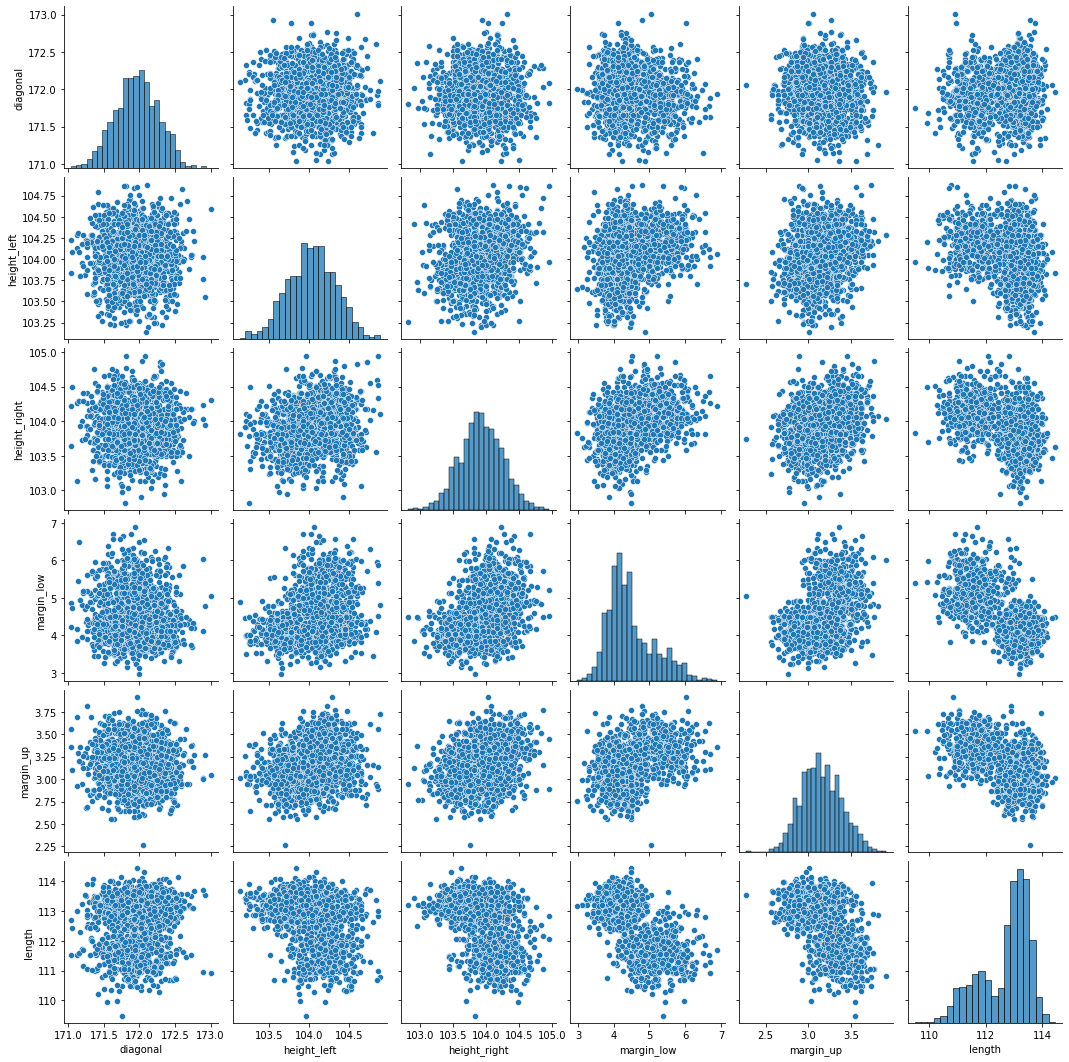

In [508]:
plt.tight_layout(pad=3.0)
sns.pairplot(df_billets_1.iloc[:,1:])
plt.show()

In [509]:
# Comparer les valeurs manquantes avant et après remplacement.
print(df_billets_1.loc[positions_index, :])

      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72          True    171.94       103.89        103.45    4.485967       3.25   
99          True    171.93       104.07        104.18    4.485967       3.14   
151         True    172.07       103.80        104.38    4.485967       3.02   
197         True    171.45       103.66        103.80    4.485967       3.62   
241         True    171.83       104.14        104.06    4.485967       3.02   
251         True    171.80       103.26        102.82    4.485967       2.95   
284         True    171.92       103.83        103.76    4.485967       3.23   
334         True    171.85       103.70        103.96    4.485967       3.00   
410         True    172.56       103.72        103.51    4.485967       3.12   
413         True    172.30       103.66        103.50    4.485967       3.16   
445         True    172.34       104.42        103.22    4.485967       3.01   
481         True    171.81       103.53 

###### Méthode 2: Autre méthode de remplacement des valeurs manquantes ==> Procéder par regression linéaire.

In [511]:
df_billets_2 = pd.read_csv(path, sep=';')
print(df_billets_2.head())

   is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54  


In [512]:
df_billets_2.isna().any()

is_genuine      False
diagonal        False
height_left     False
height_right    False
margin_low       True
margin_up       False
length          False
dtype: bool

In [513]:
train_data = df_billets_2.dropna()
train_data.isna().any()


is_genuine      False
diagonal        False
height_left     False
height_right    False
margin_low      False
margin_up       False
length          False
dtype: bool

In [514]:
train_data = train_data.iloc[:,1:]
print(train_data)

      diagonal  height_left  height_right  margin_low  margin_up  length
0       171.81       104.86        104.95        4.52       2.89  112.83
1       171.46       103.36        103.66        3.77       2.99  113.09
2       172.69       104.48        103.50        4.40       2.94  113.16
3       171.36       103.91        103.94        3.62       3.01  113.51
4       171.73       104.28        103.46        4.04       3.48  112.54
...        ...          ...           ...         ...        ...     ...
1495    171.75       104.38        104.17        4.42       3.09  111.28
1496    172.19       104.63        104.44        5.27       3.37  110.97
1497    171.80       104.01        104.12        5.51       3.36  111.95
1498    172.06       104.28        104.06        5.17       3.46  112.25
1499    171.47       104.15        103.82        4.63       3.37  112.07

[1463 rows x 6 columns]


<Figure size 432x288 with 0 Axes>

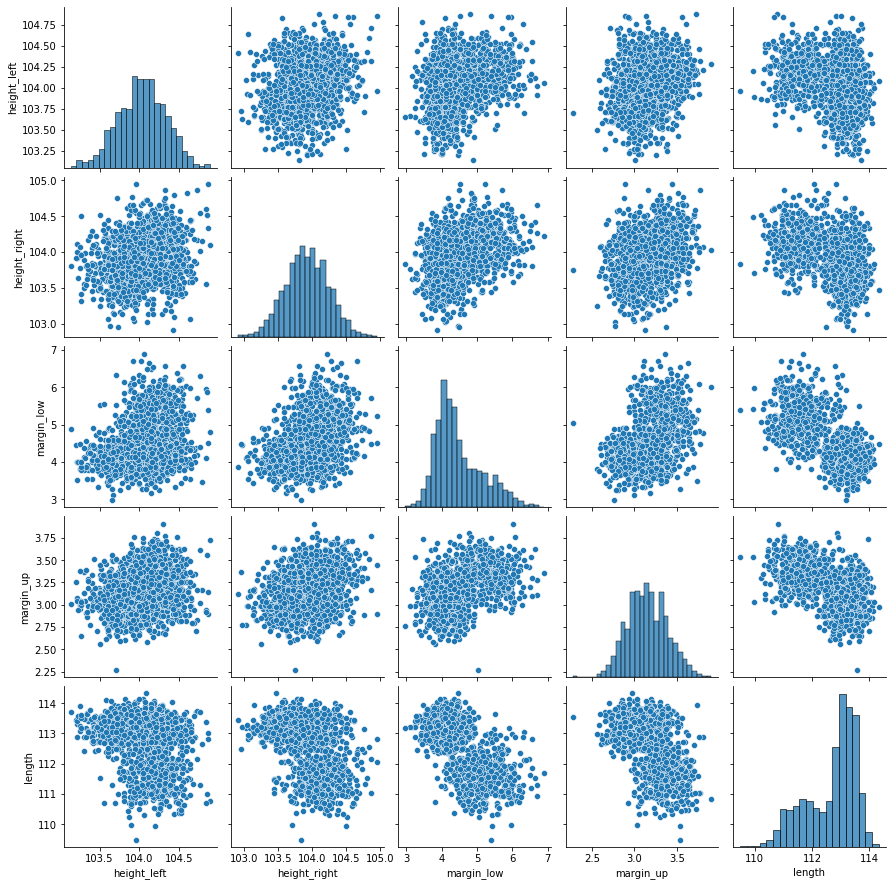

In [515]:
plt.tight_layout(pad=3.0)
sns.pairplot(train_data.iloc[:,1:])
plt.show()

In [516]:
x_train = train_data.iloc[:,np.r_[0:3,4:6]]
print(x_train.head())

   diagonal  height_left  height_right  margin_up  length
0    171.81       104.86        104.95       2.89  112.83
1    171.46       103.36        103.66       2.99  113.09
2    172.69       104.48        103.50       2.94  113.16
3    171.36       103.91        103.94       3.01  113.51
4    171.73       104.28        103.46       3.48  112.54


In [517]:
y_train = train_data.iloc[:,3:4]
print(y_train)

      margin_low
0           4.52
1           3.77
2           4.40
3           3.62
4           4.04
...          ...
1495        4.42
1496        5.27
1497        5.51
1498        5.17
1499        4.63

[1463 rows x 1 columns]


In [518]:
lr = LinearRegression()

In [519]:
lr.fit(x_train, y_train)

LinearRegression()

In [520]:
x_test = df_billets_2.iloc[:,np.r_[1:4,5:7]]
print(x_test)

      diagonal  height_left  height_right  margin_up  length
0       171.81       104.86        104.95       2.89  112.83
1       171.46       103.36        103.66       2.99  113.09
2       172.69       104.48        103.50       2.94  113.16
3       171.36       103.91        103.94       3.01  113.51
4       171.73       104.28        103.46       3.48  112.54
...        ...          ...           ...        ...     ...
1495    171.75       104.38        104.17       3.09  111.28
1496    172.19       104.63        104.44       3.37  110.97
1497    171.80       104.01        104.12       3.36  111.95
1498    172.06       104.28        104.06       3.46  112.25
1499    171.47       104.15        103.82       3.37  112.07

[1500 rows x 5 columns]


In [521]:
y_pred = lr.predict(x_test)

In [522]:
print(y_pred)
print(y_pred.shape)

[[4.78867649]
 [4.13890773]
 [4.12593262]
 ...
 [4.90027735]
 [4.80857449]
 [4.83903233]]
(1500, 1)


In [523]:
df_billets_2['y_pred'] = y_pred
print(df_billets_2)

      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length    y_pred  
0     112.83  

In [524]:
df_billets_2.loc[df_billets_2['margin_low'].isna(),'margin_low'] = df_billets_2.loc[df_billets_2['margin_low'].isna(),'y_pred']

In [525]:
df_billets_2.isna().any()

is_genuine      False
diagonal        False
height_left     False
height_right    False
margin_low      False
margin_up       False
length          False
y_pred          False
dtype: bool

In [527]:
# Comparer les valeurs manquantes avant et après remplacement.
print(df_billets_2.iloc[positions_index, 0:7])

      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72          True    171.94       103.89        103.45    4.318525       3.25   
99          True    171.93       104.07        104.18    4.393668       3.14   
151         True    172.07       103.80        104.38    4.410457       3.02   
197         True    171.45       103.66        103.80    4.319014       3.62   
241         True    171.83       104.14        104.06    4.650617       3.02   
251         True    171.80       103.26        102.82    3.803308       2.95   
284         True    171.92       103.83        103.76    4.179736       3.23   
334         True    171.85       103.70        103.96    4.127442       3.00   
410         True    172.56       103.72        103.51    4.135034       3.12   
413         True    172.30       103.66        103.50    4.160539       3.16   
445         True    172.34       104.42        103.22    4.177420       3.01   
481         True    171.81       103.53 

### 4. Analyse descriptive<a id="C4"></a>

##### 4.1. Visualisation des corrélations, loi de distribution<a id="C4.1."></a>

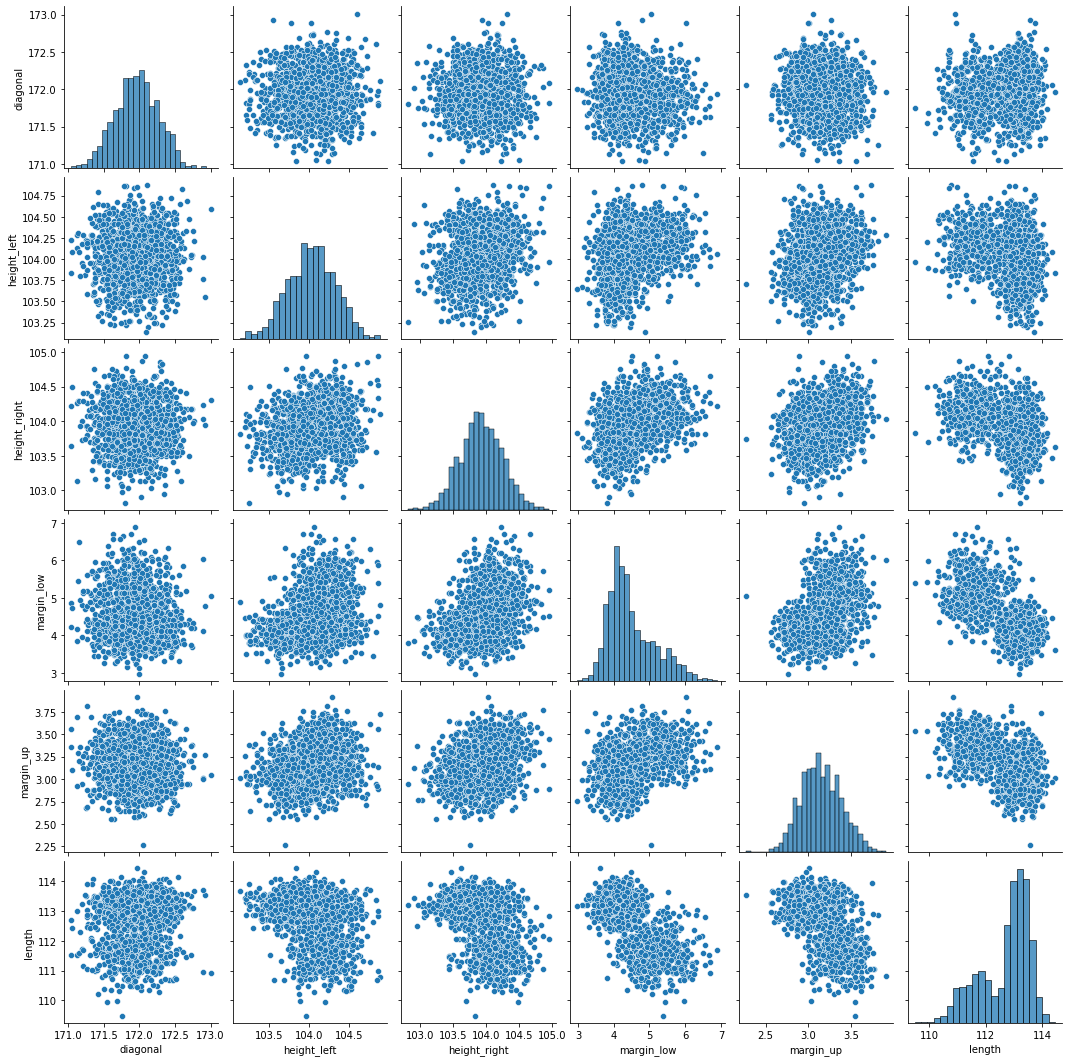

In [528]:
sns.pairplot(df_billets_2.iloc[:, 1:7])
plt.show()

###### les variables margin_low et margin_up sont inversement corrélées avec length mais positivement corrélées avec les autres variables. Pour cectte raison, les variables margin_low et margin_up et length peuvent être différentiantes.
###### A l'exception de length les densités de distribution sont assez proches de la loi normale.

###### Remplacement de la colonne is_genuine (valeurs string) par des valeurs numériques. Utile pour la suite de l'analyse.

In [529]:
# Remplacement de la colonne is_genuine (valeurs string) par des valeurs numériques.
# Utile pour la suite de l'analyse.
df_billets_2['status'] = 0

cond = df_billets_2['is_genuine'] == True
df_billets_2.loc[cond,'status'] = 1
# print(df_billets_2)

# Suppression des colonnes inutiles: y_pred
df_billets_2 = df_billets_2.drop(['y_pred'], axis=1)
print(df_billets_2.head())


   is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  status  
0  112.83       1  
1  113.09       1  
2  113.16       1  
3  113.51       1  
4  112.54       1  


In [530]:
# Prendre les noms des colonnes
col_names = df_billets_2.columns.tolist()
print(col_names)

['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length', 'status']


In [531]:
# enlever la colonne 1 pour ne conserver que les valeurs numériques
df_bill_num = df_billets_2.iloc[:,1:8]
print(df_bill_num.head())

   diagonal  height_left  height_right  margin_low  margin_up  length  status
0    171.81       104.86        104.95        4.52       2.89  112.83       1
1    171.46       103.36        103.66        3.77       2.99  113.09       1
2    172.69       104.48        103.50        4.40       2.94  113.16       1
3    171.36       103.91        103.94        3.62       3.01  113.51       1
4    171.73       104.28        103.46        4.04       3.48  112.54       1


##### 4.2. Distribution des valeurs, analyse par les quartiles<a id="C4.2."></a>

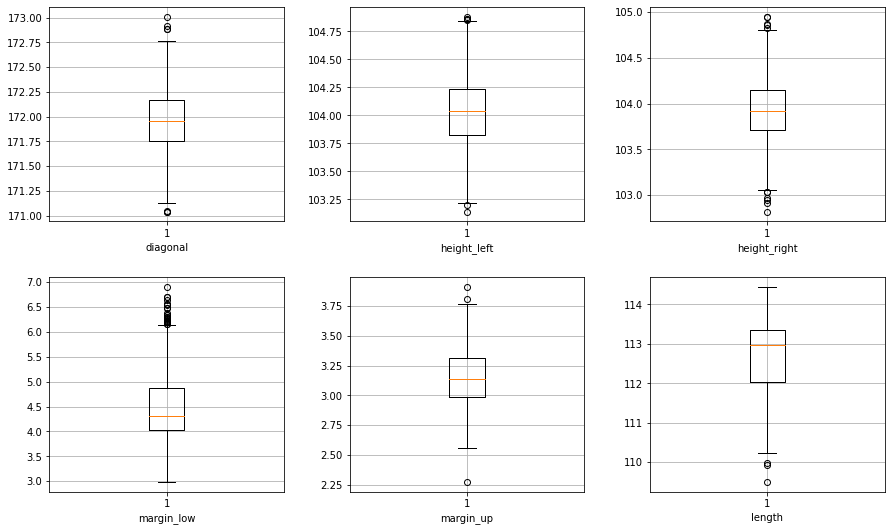

In [532]:
# Analyse des quartiles sur df_billets_2
fig, axes= plt.subplots(2, 3, figsize=(13,8))
plt.tight_layout(pad=3.5)

df_no_status = df_bill_num.iloc[:,0:6]

for i, ax in enumerate(axes.flat):
    ax.boxplot(df_no_status.iloc[:,i])
    ax.grid()
    ax.set_xlabel(df_no_status.columns[i])
plt.show()

###### Les valeurs sont regroupées autour de la médiane pour les variables 'diagonal', 'height_left', 'height_right', et 'margin_up'. Pour les autres variables, 'margin_low' et 'lenght' les valeurs ne sont pas distribuées de façon homogène, selon une cadence régulière.

##### 4.3. Signifiance des variables, test ANOVA<a id="C4.3."></a>

In [533]:
# Est ce que les variables sont significativement différentes ?
# Application d'un test ANOVA.

f_value, p_value= stats.f_oneway(df_no_status['diagonal'],df_no_status['height_left'], 
                                 df_no_status['height_right'], df_no_status['margin_low'], 
                                 df_no_status['margin_up'], df_no_status['length'])
print("Statistique de test: {}".format(f_value))
print()
print("P-Value: {}".format(p_value))

Statistique de test: 25975307.910568755

P-Value: 0.0


###### On peut conclure du test que certaines variables sont significativement différentes. Quels sont les variables significativement différentes ? Mettons en place un test de Tukey.

##### 4.4. Signifiance des variables, test de Tukey<a id="C4.4."></a>

In [534]:
long = len(df_no_status.columns)

l_cols = df_no_status.columns.tolist()

l_df_tukey = []


for i in range(long):
    df_tukey = pd.DataFrame(data=df_no_status.iloc[:,i])
    df_tukey.rename(columns={l_cols[i] : 'value'}, inplace=True)
    df_tukey['groupe'] = l_cols[i]
    l_df_tukey.append(df_tukey)

    if i == 0:
        df_concat = l_df_tukey[i]
        
    if i > 0:
    
        df_concat = pd.concat([df_concat, l_df_tukey[i]], axis=0)
        df_concat = df_concat

df_concat.reset_index(inplace=True, drop=True)    
    
print(df_concat)
print(len(df_concat))
print(type(df_concat))
print(df_concat.isna().any())
print(df_concat['groupe'].dtypes)

tukey = pairwise_tukeyhsd(endog=df_concat['value'],groups=df_concat['groupe'], alpha=0.05)
print(tukey)   




       value    groupe
0     171.81  diagonal
1     171.46  diagonal
2     172.69  diagonal
3     171.36  diagonal
4     171.73  diagonal
...      ...       ...
8995  111.28    length
8996  110.97    length
8997  111.95    length
8998  112.25    length
8999  112.07    length

[9000 rows x 2 columns]
9000
<class 'pandas.core.frame.DataFrame'>
value     False
groupe    False
dtype: bool
object
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
   group1       group2     meandiff p-adj   lower     upper   reject
--------------------------------------------------------------------
    diagonal  height_left  -67.9289  -0.0  -67.9816  -67.8762   True
    diagonal height_right  -68.0381  -0.0  -68.0909  -67.9854   True
    diagonal       length  -59.2799  -0.0  -59.3327  -59.2272   True
    diagonal   margin_low  -167.475  -0.0 -167.5277 -167.4222   True
    diagonal    margin_up  -168.807  -0.0 -168.8597 -168.7542   True
 height_left height_right   -0.1092   0.0   -0.1619  

###### Le test de Tukey renvoie des p-valeurs nulles pour chaque paire de variable comparée. On peut conclure au rejet de l'hypothèse nulle et que les variables sont toutes significativement différentes.

### 5. Méthode analyse en composantes principales<a id="C4"></a>

##### 5.1. Réduction et centrage des données<a id="C4.1."></a>

In [535]:
# enlever les libellés colonne
arr_bill = df_no_status.values
print(arr_bill)

[[171.81 104.86 104.95   4.52   2.89 112.83]
 [171.46 103.36 103.66   3.77   2.99 113.09]
 [172.69 104.48 103.5    4.4    2.94 113.16]
 ...
 [171.8  104.01 104.12   5.51   3.36 111.95]
 [172.06 104.28 104.06   5.17   3.46 112.25]
 [171.47 104.15 103.82   4.63   3.37 112.07]]


In [536]:
init = StandardScaler()
arr_bill_c_r = init.fit_transform(arr_bill)

In [537]:
# tableau des données centrées réduites
print(arr_bill_c_r)
print(arr_bill_c_r.shape)

[[-0.48653957  2.77412327  3.16324041  0.0553898  -1.128325    0.17365114]
 [-1.63372936 -2.23653528 -0.79966777 -1.08198744 -0.69679916  0.47166629]
 [ 2.3978233   1.50475644 -1.29119126 -0.12659056 -0.91256208  0.55190114]
 ...
 [-0.51931643 -0.06524991  0.61346228  1.55672775  0.89984645 -0.83501554]
 [ 0.3328817   0.83666863  0.42914097  1.04111674  1.33137229 -0.4911519 ]
 [-1.6009525   0.40241156 -0.30814427  0.22220513  0.94299904 -0.69747008]]
(1500, 6)


In [538]:
# Y a t-il des variables significativement différentes ?
# Est ce que la différence de la moyenne d'une variable est significative ?
# Mettons en place un test ANOVA.

# Convertir le tableau des variables centrées réduites en df. 
df_bill_c_r = pd.DataFrame(arr_bill_c_r, columns=['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length'])
print(df_bill_c_r.head())
print(df_bill_c_r.shape)




   diagonal  height_left  height_right  margin_low  margin_up    length
0 -0.486540     2.774123      3.163240    0.055390  -1.128325  0.173651
1 -1.633729    -2.236535     -0.799668   -1.081987  -0.696799  0.471666
2  2.397823     1.504756     -1.291191   -0.126591  -0.912562  0.551901
3 -1.961498    -0.399294      0.060498   -1.309463  -0.610494  0.953075
4 -0.748754     0.836669     -1.414072   -0.672532   1.417677 -0.158750
(1500, 6)


In [539]:
# vérification valeur moyenne des données
print(np.mean(arr_bill_c_r))

-9.638117464621447e-15


In [540]:
# # vérification écart type des données
print(np.std(arr_bill_c_r))

1.0


##### 5.2. Détermination composantes principales<a id="C4.2."></a>

In [541]:
# instanciation méthode ACP
acp = PCA(svd_solver='full')

In [542]:
print(acp)

PCA(svd_solver='full')


In [543]:
coord = acp.fit_transform(arr_bill_c_r)
print(coord)
print(coord.shape)

[[ 1.64413533  0.74784336  2.40251671  3.18085156  0.30398483 -0.01224666]
 [-2.01990995 -2.20749245 -1.00186403  0.07293664  0.03333482 -0.47550345]
 [-0.969864    2.62049228  1.19536388 -0.92362716 -0.83774922  0.2073435 ]
 ...
 [ 1.88968443 -0.60028209 -0.54592206 -0.09804235 -0.29697655  0.50356217]
 [ 1.78978258  0.51122987  0.02810393 -0.47401805  0.35665494  0.52471865]
 [ 1.04215891 -1.47130226  0.48443988 -0.68518566  0.48451961 -0.23511175]]
(1500, 6)


##### 5.3. Détermination du nombre de composantes<a id="4.3."></a>

In [544]:
# Variance expliquée
exp_var = acp.explained_variance_
print(exp_var)

[2.59902788 1.01807567 0.7820251  0.70996559 0.57654658 0.31836184]


In [545]:
df_exp_var = pd.DataFrame({'val_pro': exp_var})
print(df_exp_var)

    val_pro
0  2.599028
1  1.018076
2  0.782025
3  0.709966
4  0.576547
5  0.318362


In [546]:
df_exp_var['val_pro_cum'] = df_exp_var['val_pro'].cumsum()

In [547]:
print(df_exp_var)

    val_pro  val_pro_cum
0  2.599028     2.599028
1  1.018076     3.617104
2  0.782025     4.399129
3  0.709966     5.109094
4  0.576547     5.685641
5  0.318362     6.004003


In [548]:
df_exp_var['val_pro_cum_%'] = df_exp_var['val_pro_cum']/df_exp_var['val_pro'].sum()
print(df_exp_var)

    val_pro  val_pro_cum  val_pro_cum_%
0  2.599028     2.599028       0.432883
1  1.018076     3.617104       0.602449
2  0.782025     4.399129       0.732699
3  0.709966     5.109094       0.850948
4  0.576547     5.685641       0.946975
5  0.318362     6.004003       1.000000


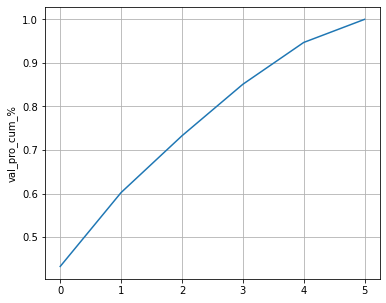

In [549]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
sns.lineplot(data=df_exp_var, x= df_exp_var.index, y='val_pro_cum_%', ax=ax)
ax.grid()
plt.show()

###### Avec les 3 premières valeurs propres on capte 75% de l'information originelle. On choisira donc de travailler avec ces 3 composantes.

##### 5.4. Représentation des individus sur plans factoriels<a id="C4.4."></a>

In [550]:
# calculons les vecteurs propres (projection des vecteurs originels dans la nouvelle base des vecteurs propres)
vec = acp.components_
print(vec)
print(vec.shape)


[[-0.08469767  0.33063448  0.39355544  0.50769282  0.4394146  -0.52705225]
 [ 0.94130387  0.30752844  0.10833184 -0.07243963 -0.00495445  0.04863598]
 [-0.28784296  0.88504887 -0.16356327 -0.10904608 -0.27011168  0.14909938]
 [-0.10196124 -0.04924399  0.86656155 -0.08927108 -0.44404699  0.17636033]
 [-0.11599182  0.10165163  0.23599848 -0.56408757  0.71198772  0.30886283]
 [ 0.0083408   0.00613019  0.00109087  0.6316212   0.17270117  0.75572523]]
(6, 6)


In [551]:
# Convertir le tableau des vecteurs propres en df pour simplifer les calculs 
df_vec = pd.DataFrame(vec, columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6'])
print(df_vec)


         V1        V2        V3        V4        V5        V6
0 -0.084698  0.330634  0.393555  0.507693  0.439415 -0.527052
1  0.941304  0.307528  0.108332 -0.072440 -0.004954  0.048636
2 -0.287843  0.885049 -0.163563 -0.109046 -0.270112  0.149099
3 -0.101961 -0.049244  0.866562 -0.089271 -0.444047  0.176360
4 -0.115992  0.101652  0.235998 -0.564088  0.711988  0.308863
5  0.008341  0.006130  0.001091  0.631621  0.172701  0.755725


In [552]:
# Convertir le tableau des variables centrées réduites en df pour simplifer les calculs 
df_bill_c_r = pd.DataFrame(arr_bill_c_r, columns=['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length'])
print(df_bill_c_r.head())
print(df_bill_c_r.shape)

   diagonal  height_left  height_right  margin_low  margin_up    length
0 -0.486540     2.774123      3.163240    0.055390  -1.128325  0.173651
1 -1.633729    -2.236535     -0.799668   -1.081987  -0.696799  0.471666
2  2.397823     1.504756     -1.291191   -0.126591  -0.912562  0.551901
3 -1.961498    -0.399294      0.060498   -1.309463  -0.610494  0.953075
4 -0.748754     0.836669     -1.414072   -0.672532   1.417677 -0.158750
(1500, 6)


In [553]:
# Projection des individus sur 1er plan factoriel
# représentons le produit matriciel entre individus et les deux axes de projection.

print(df_bill_c_r.head())
print(df_bill_c_r.shape)
print()
print(df_vec.iloc[:,0:3])
print(df_vec.iloc[:,0:3].shape)
print(type(df_vec.iloc[:,0:3]))


   diagonal  height_left  height_right  margin_low  margin_up    length
0 -0.486540     2.774123      3.163240    0.055390  -1.128325  0.173651
1 -1.633729    -2.236535     -0.799668   -1.081987  -0.696799  0.471666
2  2.397823     1.504756     -1.291191   -0.126591  -0.912562  0.551901
3 -1.961498    -0.399294      0.060498   -1.309463  -0.610494  0.953075
4 -0.748754     0.836669     -1.414072   -0.672532   1.417677 -0.158750
(1500, 6)

         V1        V2        V3
0 -0.084698  0.330634  0.393555
1  0.941304  0.307528  0.108332
2 -0.287843  0.885049 -0.163563
3 -0.101961 -0.049244  0.866562
4 -0.115992  0.101652  0.235998
5  0.008341  0.006130  0.001091
(6, 3)
<class 'pandas.core.frame.DataFrame'>


In [554]:
# Avant de faire le produit matriciel, il faut faire coïncider les deux index des deux df, autrement 
# on génère une erreur

df_vec_new_index = df_vec.rename(index={0:'diagonal', 1:'height_left', 2:'height_right', 3:'margin_low', 4:'margin_up', 5:'length'})
print(df_vec_new_index)

# Affichage des vecteurs sur lesquels on va projeter les individus:
print(df_vec_new_index.iloc[:,0:3])



    

                    V1        V2        V3        V4        V5        V6
diagonal     -0.084698  0.330634  0.393555  0.507693  0.439415 -0.527052
height_left   0.941304  0.307528  0.108332 -0.072440 -0.004954  0.048636
height_right -0.287843  0.885049 -0.163563 -0.109046 -0.270112  0.149099
margin_low   -0.101961 -0.049244  0.866562 -0.089271 -0.444047  0.176360
margin_up    -0.115992  0.101652  0.235998 -0.564088  0.711988  0.308863
length        0.008341  0.006130  0.001091  0.631621  0.172701  0.755725
                    V1        V2        V3
diagonal     -0.084698  0.330634  0.393555
height_left   0.941304  0.307528  0.108332
height_right -0.287843  0.885049 -0.163563
margin_low   -0.101961 -0.049244  0.866562
margin_up    -0.115992  0.101652  0.235998
length        0.008341  0.006130  0.001091


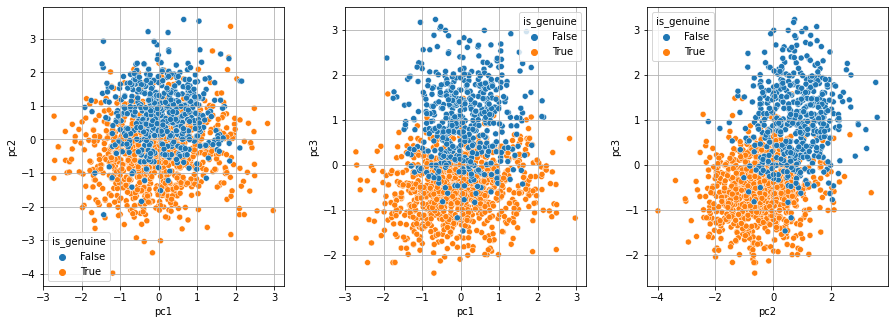

In [556]:
# Projection des individus sur plans factoriels
n_rows = 1
n_cols = 3


dim = np.array([[0,1], [0,2], [1,2]])
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 5))
plt.tight_layout(pad=3.0)


for i in range(n_rows):
    for col, ax in enumerate(axes.flat):
                
        x_pc = df_bill_c_r.dot(df_vec_new_index.iloc[:,dim[col][0]])
        
        y_pc = df_bill_c_r.dot(df_vec_new_index.iloc[:,dim[col][1]])
        
                
        ax.grid()
        ax.set_xlabel('pc'+ str(dim[col][0] + 1))
        ax.set_ylabel('pc'+ str(dim[col][1] + 1))
        
        sns.scatterplot(x=x_pc,y=y_pc, ax=ax, hue=df_billets_2['is_genuine'])
    plt.show()

###### A l'issue de la projection des individus sur les vecteurs, on visualise assez bien deux groupes d'individus mais la méthode ACP reste inopérante à départager nettement les deux groupes d'individus. Ce n'est pas une méthode que l'on peut utiliser pour réaliser cette détection.

##### 5.5. Représentation des variables synthétiques en fonction des variables originelles<a id="C4.5."></a>

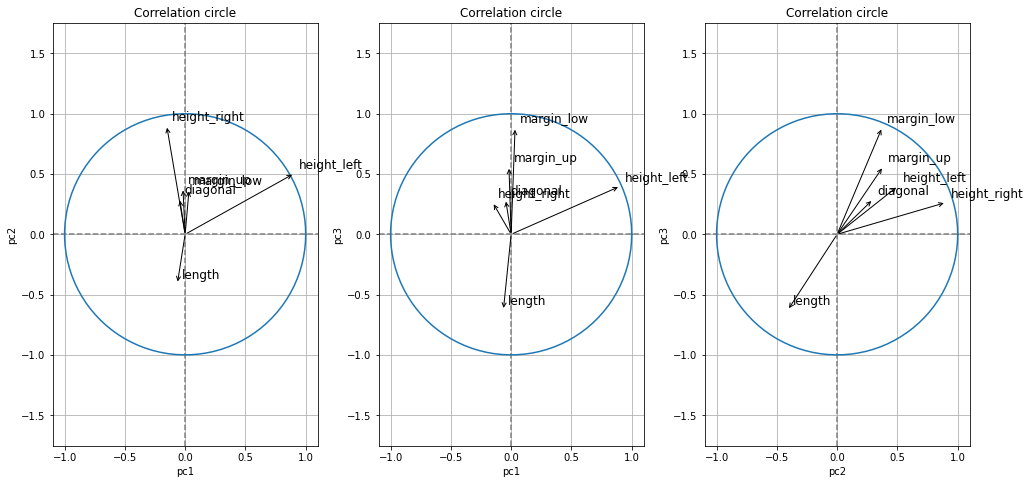

In [557]:
# Représentation des variables originelles sur les axes 1 et 2, premier plan factoriel.
n_rows = 1
n_cols = 3



dim = np.array([[0,1], [0,2], [1,2]])
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 7))
plt.tight_layout(pad=3.0)



for i in range(n_rows):
    for col, ax in enumerate(axes.flat):
                
        x_pc = df_bill_c_r.dot(df_vec_new_index.iloc[:,dim[col][0]])
        
        y_pc = df_bill_c_r.dot(df_vec_new_index.iloc[:,dim[col][1]])

        
        for k in range(len(df_bill_c_r.columns)):
            x_corr = pd.concat([df_bill_c_r.iloc[:,k], x_pc], axis=1).corr()
        
            y_corr = pd.concat([df_bill_c_r.iloc[:,k], y_pc], axis=1).corr()
        
            x = x_corr.iloc[0,1]
            y = y_corr.iloc[0,1]
            
    
            ax.annotate("", xy= (x,y), xytext=(0, 0),arrowprops=dict(arrowstyle="->"))
            ax.annotate(df_bill_c_r.columns[k], (x+0.04,y+0.04), size=12)
    
        
        ax.axhline(y=0, color="grey", linestyle="--")
        ax.axvline(x=0, color="grey", linestyle="--")

        an = np.linspace(0, 2 * np.pi, 100)
        ax.plot(np.cos(an), np.sin(an))
        ax.axis('equal')
    
        ax.set_title('Correlation circle')
        ax.set_xlabel('pc' + str(dim[col][0]+1))
        ax.set_ylabel('pc' + str(dim[col][1]+1))
    
        ax.grid()
    plt.show()


##### 5.6. Représentation corrélation entre variables synthétiques et originelles<a id="C4.6."></a>

In [558]:
# Construire une heatmap pour faire apparaitre les relations entre variables orginelles et variables synthétiques.
df_concat = pd.concat([df_bill_c_r, df_vec.iloc[:,0:2]], axis=1)
df_concat.corr()
print(df_concat.corr())

              diagonal  height_left  height_right  margin_low  margin_up  \
diagonal      1.000000     0.019472     -0.024492   -0.110697  -0.055649   
height_left   0.019472     1.000000      0.242279    0.309209   0.246522   
height_right -0.024492     0.242279      1.000000    0.393541   0.307005   
margin_low   -0.110697     0.309209      0.393541    1.000000   0.434237   
margin_up    -0.055649     0.246522      0.307005    0.434237   1.000000   
length        0.097587    -0.320863     -0.401751   -0.670966  -0.520575   
V1           -0.501131    -0.731533     -0.132404   -0.461913  -0.115123   
V2            0.704375     0.408188     -0.186003    0.432390  -0.303913   

                length        V1        V2  
diagonal      0.097587 -0.501131  0.704375  
height_left  -0.320863 -0.731533  0.408188  
height_right -0.401751 -0.132404 -0.186003  
margin_low   -0.670966 -0.461913  0.432390  
margin_up    -0.520575 -0.115123 -0.303913  
length        1.000000  0.075565  0.096910  


In [559]:
df_heatmap = df_concat.corr().iloc[0:6, 6:8]
print(df_heatmap)

                    V1        V2
diagonal     -0.501131  0.704375
height_left  -0.731533  0.408188
height_right -0.132404 -0.186003
margin_low   -0.461913  0.432390
margin_up    -0.115123 -0.303913
length        0.075565  0.096910


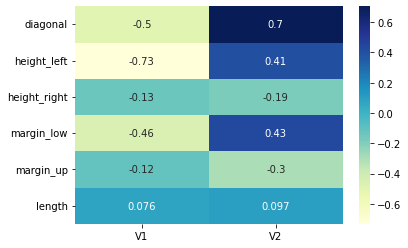

In [560]:
sns.heatmap(df_heatmap, cmap="YlGnBu", annot=True)
plt.show()

### 6. Méthode des K-Means<a id="C5."></a>

##### 6.1. Importance des données d'entrée<a id="C6.1."></a>

###### Il peut être intéressant de constater la capacité de la méthode K-Means à générer des résultats probants fonction de la qualité des données qu'on lui fournit. Nous allons successivement prendre trois jeux de données d'entrée avec des qualité différentes. Commençons par un jeu de données construit à partir de la projection des individus successivement sur les 3 plans factoriels de l'ACP. Dans ce cas les coordonnées x, y de chaque individu sont fonction de deux variables synthétiques dont la variance cumulée est inférieure ou égale à 60% de l'information originelle. Dans un 2ème temps, nous utiliserons un jeu de données construit à partir de la projection des individus sur les 3 premières comp. princp. simulatanément. Dans ce cas, l'information capturée par les 3 premières comp. princ. est de 73,2%. Puis dans le 3 ème cas nous utiliserons les données originelles centrées réduites. Dans ce dernier cas nous utilisons 100% de l'information disponible pour générer le K-Means.

##### 6.2. 1° cas: données d'entrée à partir de la projection sur 2 comp. princ.<a id="C6.2."></a>

[[612.   0.]
 [  0.   0.]]
[[612.   0.]
 [  0.  88.]]
[[612.   0.]
 [412.  88.]]
[[612. 388.]
 [412.  88.]]
    x_centr   y_centr is_genuine
0 -0.317530 -0.873027       True
1  0.276354  0.759816      False
[[868.   0.]
 [  0.   0.]]
[[868.   0.]
 [  0.  97.]]
[[868.   0.]
 [403.  97.]]
[[868. 132.]
 [403.  97.]]
    x_centr   y_centr is_genuine
0 -0.183226 -0.600178       True
1  0.330493  1.082565      False
[[818.   0.]
 [  0.   0.]]
[[818.   0.]
 [  0.  49.]]
[[818.   0.]
 [451.  49.]]
[[818. 182.]
 [451.  49.]]
    x_centr   y_centr is_genuine
0 -0.619757 -0.613632       True
1  0.848861  0.840472      False


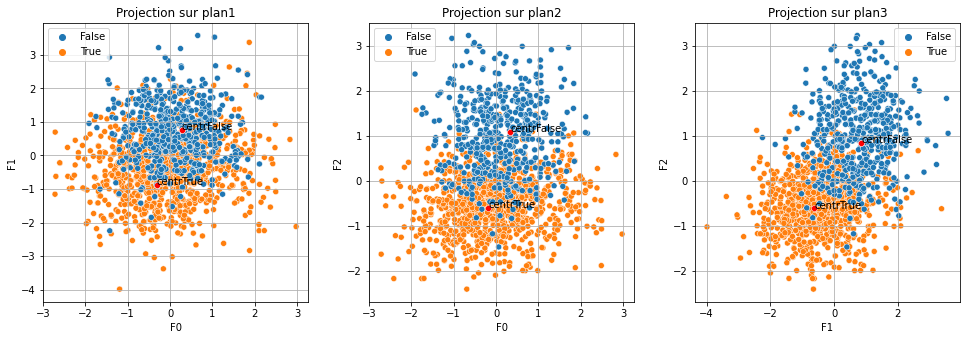

In [561]:
# Création listes actuals_true/false et predict_true/false
arr_check = np.zeros([2,2])
l_arr = []


# Projection des individus sur plans factoriels
plans = [[0,1], [0,2], [1,2]]

fig, axes = plt.subplots(1,3, figsize=(14,5))
plt.tight_layout(pad=3.0)

for i, ax in enumerate(axes.flat):
    x_proj = df_bill_c_r.dot(df_vec_new_index.iloc[:,plans[i][0]])        
    y_proj = df_bill_c_r.dot(df_vec_new_index.iloc[:,plans[i][1]])    
    
    
    d = {'F' + str(plans[i][0]): x_proj,'F' + str(plans[i][1]): y_proj}
    df_ind_proj = pd.DataFrame(d)

    
    # Application K-Means sur chaque df.
    # Initialisation
    kmeans_1 = KMeans(init="random",
                    n_clusters=2,
                    n_init=10,
                    max_iter=300,
                    random_state=42)
    
    kmeans_1.fit(df_ind_proj)
    
    
    # Construction des clusters et création variable clusters pour chq df.
    clusters = kmeans_1.labels_
    df_ind_proj['clusters'] = clusters
    
    
    # Voir la correspondance entre billets vrais/faux et clusters
    df_check = pd.concat([df_ind_proj,df_billets_2['is_genuine']], axis=1)    
    
    df_check = df_check[['is_genuine','clusters']]
    # ==> La correspondance s'établit ainsi: 0 correspond à True, 1 correspond à False
    
    
    # Préparation des données pour construction de la matrice de confusion.
    arr_check = np.zeros([2,2])
    
    cond1 = (df_check['clusters'] == 0) & (df_check['is_genuine'] == True)
    cond2 = (df_check['clusters'] == 1) & (df_check['is_genuine'] == False)
    
    cond3 = (df_check['clusters'] == 0) & (df_check['is_genuine'] == False)
    cond4 = (df_check['clusters'] == 1) & (df_check['is_genuine'] == True)

    
    p_a_true_true = df_check.loc[cond1,'is_genuine'].count()
    arr_check[0][0] = p_a_true_true
    print(arr_check)
    
    
    p_a_false_false = df_check.loc[cond3,'is_genuine'].count()
    arr_check[1][1] = p_a_false_false
    print(arr_check)
    
    
    p_a_true_false = df_check.loc[cond2,'is_genuine'].count()
    arr_check[1][0] = p_a_true_false
    print(arr_check)
    
    
    p_a_false_true = df_check.loc[cond4,'is_genuine'].count()
    arr_check[0][1] = p_a_false_true
    print(arr_check)
    
    l_arr.append(arr_check)
    # Remise à zero du tableau
    arr_check = np.zeros([2,2])


    

    
    
    # Récupération des centroids pour chq projection des points sur les axes.
    centroids = kmeans_1.cluster_centers_
    # print(centroids)
    
    # Mettre les coordonnées x, y des centroids ds un df. Ajouter colonne 'is_genuine'.
    df_centr = pd.DataFrame(centroids, columns=['x_centr', 'y_centr'])
    df_centr['is_genuine'] = 'False'
    df_centr.loc[df_centr.index == 0,'is_genuine'] = 'True'
    print(df_centr)
    
    
    # Affichage des coordonnées x, y des individus projetés.
    sns.scatterplot(x=df_ind_proj.iloc[:,0], y = df_ind_proj.iloc[:,1], hue=df_check.loc[:,'is_genuine'], ax=ax)
    
    
    # Calculer les coordonnées x, y des centroids.
    for index in df_centr.index:
        sns.scatterplot(x= df_centr.iloc[index:,0], y=df_centr.iloc[index:,1], color='red', ax=ax)
        
    # Afficher le texte lié à chq centroid.
    for l in range(len(df_centr)):
        anno = 'centr' + df_centr.iloc[l,2]
        ax.annotate(anno, xy=(df_centr.iloc[l, 0], df_centr.iloc[l, 1]))
        
    
    # Afficher grille et titre
    ax.grid()
    ax.set_title('Projection sur plan' + str(i+1))



plt.show()

###### 6.3. Matrice de confusion - cas 1<a id="C6.3."></a>

In [562]:
# Confusion matrix
print(l_arr)        

[array([[612., 388.],
       [412.,  88.]]), array([[868., 132.],
       [403.,  97.]]), array([[818., 182.],
       [451.,  49.]])]


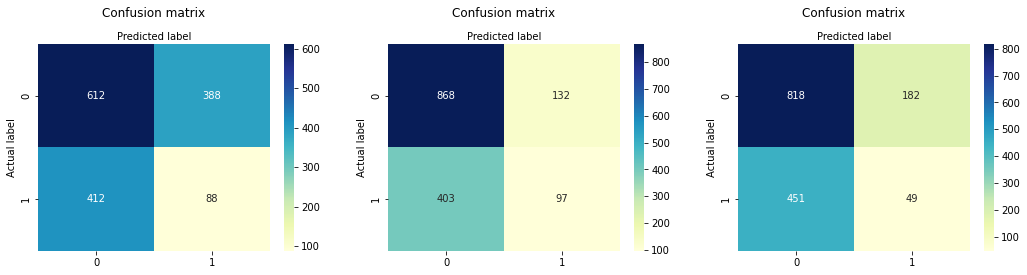

In [563]:
# Confusion matrix
class_names=[0,1] # name  of classes
fig, axes = plt.subplots(1, 3, figsize=(15,4))
plt.tight_layout(pad=3.0)

tick_marks = np.arange(len(class_names))

for i, ax in enumerate(axes.flat):
    ax.set_xticks(tick_marks, class_names)
    ax.set_yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(l_arr[i], annot=True, cmap="YlGnBu" ,fmt='g', ax=ax)
    ax.xaxis.set_label_position("top")

    ax.set_title('Confusion matrix', y=1.1)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
plt.show()

In [564]:
print(l_arr[0].T)


[[612. 412.]
 [388.  88.]]


In [565]:
# Synthèse: récapitulatif des données de sortie dans un df.
# 1. Préparation
l_df_conf = []

def conf_matrix(l_arr): # l_arr liste de plusieurs array
    for i in range(len(l_arr)):
        arr = l_arr[i]
        arr = arr.T
        df_conf = pd.DataFrame({'pf' + str(i+1) + 'prédit_vrai':[arr[0][0], arr[0][1]], 
                               'pf' + str(i+1) + 'prédit_faux': [arr[1][0], arr[1][1]]}, 
                              index=['actuals_vrai', 'actuals_faux'])
        
        tot = (df_conf.sum()).sum()
        
        df_conf = df_conf.loc[:,:].apply(lambda x: x/tot)
        
        l_df_conf.append(df_conf)
    return l_df_conf

        
conf_matrix(l_arr)


[              pf1prédit_vrai  pf1prédit_faux
 actuals_vrai        0.408000        0.258667
 actuals_faux        0.274667        0.058667,
               pf2prédit_vrai  pf2prédit_faux
 actuals_vrai        0.578667        0.088000
 actuals_faux        0.268667        0.064667,
               pf3prédit_vrai  pf3prédit_faux
 actuals_vrai        0.545333        0.121333
 actuals_faux        0.300667        0.032667]

In [566]:
# Sommation des bonnes et mauvaises prédictions.
l_d=[]
def good_bad(l):
    for i in range(int(len(l))):
        element = l[i]
        gg = element.iloc[0,0]
        bb = element.iloc[1,1]
        gb = element.iloc[1,0]
        bg = element.iloc[0,1]
        g_p = gg + bb
        b_p = gb + bg
        d = {'plan'+str(i+1): [g_p, b_p]}
        l_d.append(d)
        
    return l_d

good_bad(l_df_conf)
    
    

[{'plan1': [0.4666666666666666, 0.5333333333333333]},
 {'plan2': [0.6433333333333333, 0.3566666666666667]},
 {'plan3': [0.578, 0.42200000000000004]}]

In [567]:
# Présentation dans un df.

def prez(l_dict):
    for i in range(len(l_dict)):
        df_g_b = pd.DataFrame(l_dict[i], index=['good_pred', 'bad_pred'])
        
        if i == 0:
            df_g_b_concat = df_g_b
            
        if i>0:
            df_g_b_concat= pd.concat([df_g_b_concat,df_g_b], axis=1)
            # df_g_b_concat = df_g_b_concat
            
    return df_g_b_concat
    
prez(l_d)


,plan1,plan2,plan3
good_pred,0.466667,0.643333,0.578
bad_pred,0.533333,0.356667,0.422


###### Le partitionnement avec la méthodes des K-Means rélisé sur les plans factoriels 1, 2 et 3 donnent en synthèse les résultats ci-dessus. On note que les résultats obtenus sont meilleurs pour le plan 2. Le plan 2 est donc celui qui représente le mieux les variables originelles significatives et permet le meilleur partitionnement.

###### 6.4. 2° cas: données d'entrée à partir de la projection sur 3 comp. princ.<a id="C6.4."></a>

In [568]:
# Calculons la projection des individus sur les 3 composantes principales.
df_matrix_comp_princ = df_bill_c_r.dot(df_vec_new_index.iloc[:, 0:3])

# Nommage des colonnes qui représentent maintenant les comp. princ.
df_matrix_comp_princ.rename(columns={'V1':'pc1', 'V2':'pc2', 'V3':'pc3'}, inplace=True)

In [569]:
# Sur ce nouvel ensemble de données qui représente 73% de l'information originelle, appliquons un K-Means.
# diagonal  height_left  height_right  margin_low  margin_up    length
df_matrix_comp_princ

,pc1,pc2,pc3
0,1.868662,3.375518,-0.626439
1,-1.541630,-1.950368,-1.855993
2,1.708364,0.029645,0.993421
3,-0.014860,-0.709521,-2.102876
4,1.160817,-1.065533,-0.221142
...,...,...,...
1495,0.966282,0.780974,-0.415284
1496,1.116930,2.305897,1.508881
1497,-0.464081,0.360867,1.248664
1498,0.371161,0.828229,1.367311


In [570]:
# Initialisation du K-Means
kmeans_2 = KMeans(init="random",
                    n_clusters=2,
                    n_init=10,
                    max_iter=300,
                    random_state=42)

In [571]:
# Application du K-Means sur df_matrix_comp_princ
kmeans_2.fit(df_matrix_comp_princ)

KMeans(init='random', n_clusters=2, random_state=42)

In [572]:
clusters = kmeans_2.labels_
df_matrix_comp_princ['clusters'] = clusters

In [573]:
df_matrix_comp_princ

,pc1,pc2,pc3,clusters
0,1.868662,3.375518,-0.626439,1
1,-1.541630,-1.950368,-1.855993,0
2,1.708364,0.029645,0.993421,1
3,-0.014860,-0.709521,-2.102876,0
4,1.160817,-1.065533,-0.221142,0
...,...,...,...,...
1495,0.966282,0.780974,-0.415284,1
1496,1.116930,2.305897,1.508881,1
1497,-0.464081,0.360867,1.248664,1
1498,0.371161,0.828229,1.367311,1


In [574]:
# Récupération des centroids
centroids = kmeans_2.cluster_centers_

In [575]:
centroids

array([[-0.1748698 , -0.64572502, -0.62700148],
       [ 0.22136087,  0.81739814,  0.79369673]])

In [576]:
df_centr = pd.DataFrame(centroids.T, columns=['centr_1', 'centr_2'])

In [577]:
df_centr

,centr_1,centr_2
0,-0.174870,0.221361
1,-0.645725,0.817398
2,-0.627001,0.793697


In [578]:
print(df_centr.iloc[0,0])

-0.17486980034011873


Int64Index([0, 1], dtype='int64', name='clusters')


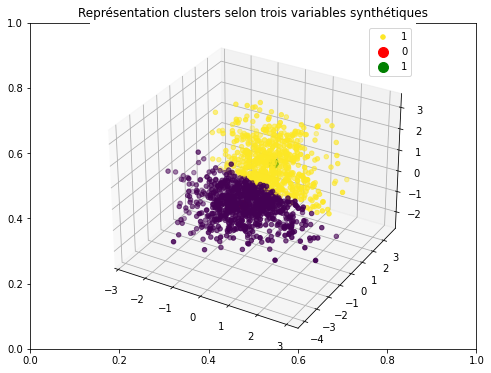

In [579]:
# Représentation graphique des clusters
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
ax = fig.add_subplot(111, projection = '3d')

x = df_matrix_comp_princ.loc[:,'pc1']
y = df_matrix_comp_princ.loc[:,'pc2']
z = df_matrix_comp_princ.loc[:,'pc3']


print(df_matrix_comp_princ.groupby(['clusters'])[['pc1', 'pc2', 'pc3']].sum().index)

ax.scatter(x, y, z, c=df_matrix_comp_princ['clusters'])

    
l = []
for i in df_centr.index:
    l.append(df_centr.iloc[i,0])
ax.scatter(l[0], l[1], l[2], c='red', s=100)

l=[]
for i in df_centr.index:
    l.append(df_centr.iloc[i,1])
ax.scatter(l[0], l[1], l[2], c='green', s=100)

ax.set_title('Représentation clusters selon trois variables synthétiques')
ax.legend(df_matrix_comp_princ['clusters'], scatterpoints=1)

plt.show()

In [580]:
# Préparation matrice de confusion
df_matrix_comp_princ['is_genuine'] = df_billets_2['is_genuine']

In [581]:
df_matrix_comp_princ.head()

,pc1,pc2,pc3,clusters,is_genuine
0,1.868662,3.375518,-0.626439,1,True
1,-1.541630,-1.950368,-1.855993,0,True
2,1.708364,0.029645,0.993421,1,True
3,-0.014860,-0.709521,-2.102876,0,True
4,1.160817,-1.065533,-0.221142,0,True


In [582]:
# Déterminer les conditions pour filtrer les résultats

# 1. cond_1: vrai - vrai
cond_1 = (df_matrix_comp_princ['clusters'] == 0) & (df_matrix_comp_princ['is_genuine'] == True)
v_v = df_matrix_comp_princ.loc[cond_1, 'clusters'].count()
print(v_v)

# 2. cond_2: faux - faux
cond_2 = (df_matrix_comp_princ['clusters'] == 1) & (df_matrix_comp_princ['is_genuine'] == False)
f_f = df_matrix_comp_princ.loc[cond_2, 'clusters'].count()
print(f_f)

# 3. cond_3: vrai - faux
cond_3 = (df_matrix_comp_princ['clusters'] == 0) & (df_matrix_comp_princ['is_genuine'] == False)
v_f = df_matrix_comp_princ.loc[cond_3, 'clusters'].count()
print(v_f)

# 4. cond_4: faux - vrai
cond_4 = (df_matrix_comp_princ['clusters'] == 1) & (df_matrix_comp_princ['is_genuine'] == True)
f_v = df_matrix_comp_princ.loc[cond_4, 'clusters'].count()
print(f_v)

tot = v_v+f_f+v_f+f_v

796
456
44
204


In [583]:
arr_conf = np.array([2,2])
arr_conf = ([v_v,f_v], [v_f, f_f])

In [584]:
df_conf = pd.DataFrame({'Valeur': [v_v+f_f, v_f+f_v], '%':[round((v_v+f_f)/tot, 2),round((v_f+f_v)/tot, 2)]}, index=['good_pred', 'bad_pred'])

In [585]:
df_conf

,Valeur,%
good_pred,1252,0.83
bad_pred,248,0.17


###### 6.5. Matrice de confusion - cas 2<a id="C6.5."></a>

In [586]:
arr_conf

([796, 204], [44, 456])

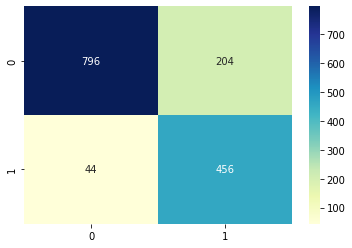

In [587]:
# Confusion matrix
class_names=[0,1] # name  of classes
fig, axes = plt.subplots(1, 1, figsize=(6,4))

tick_marks = np.arange(len(class_names))

ax.set_xticks(tick_marks, class_names)
ax.set_yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(arr_conf, annot=True, cmap="YlGnBu" ,fmt='g', ax=axes)
ax.xaxis.set_label_position("top")

ax.set_title('Confusion matrix', y=1.1)
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label')
plt.show()

In [588]:
v_v=0
f_f=0
v_f=0
f_v=0
tot=0

###### Suite à cette 2ème analyse on voit que l'on améliore significativement la performance du K-Means en ayant mieux sélectionné nos données d'entrée.

###### 6.6. 3° cas: données d'entrée à partir des variables originelles<a id="C6.6."></a>

In [677]:
# Initialisation du K-Means
kmeans_3 = KMeans(init="random",
                    n_clusters=2,
                    n_init=10,
                    max_iter=300,
                    random_state=42)

In [678]:
kmeans_3.fit(df_bill_c_r)

KMeans(init='random', n_clusters=2, random_state=42)

In [679]:
clusters = kmeans_3.labels_

In [680]:
df_bill_c_r['clusters'] = clusters

In [681]:
df_bill_c_r.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,clusters,is_genuine
0,-0.486540,2.774123,3.163240,0.055390,-1.128325,0.173651,1,True
1,-1.633729,-2.236535,-0.799668,-1.081987,-0.696799,0.471666,0,True
2,2.397823,1.504756,-1.291191,-0.126591,-0.912562,0.551901,0,True
3,-1.961498,-0.399294,0.060498,-1.309463,-0.610494,0.953075,0,True
4,-0.748754,0.836669,-1.414072,-0.672532,1.417677,-0.158750,0,True


In [682]:
# Préparation matrice de confusion
df_bill_c_r['is_genuine'] = df_billets_2['is_genuine']

In [683]:
df_bill_c_r.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,clusters,is_genuine
0,-0.486540,2.774123,3.163240,0.055390,-1.128325,0.173651,1,True
1,-1.633729,-2.236535,-0.799668,-1.081987,-0.696799,0.471666,0,True
2,2.397823,1.504756,-1.291191,-0.126591,-0.912562,0.551901,0,True
3,-1.961498,-0.399294,0.060498,-1.309463,-0.610494,0.953075,0,True
4,-0.748754,0.836669,-1.414072,-0.672532,1.417677,-0.158750,0,True


In [684]:
# Déterminer les conditions pour filtrer les résultats

# 1. cond_1: vrai - vrai
cond_1 = (df_bill_c_r['clusters'] == 0) & (df_bill_c_r['is_genuine'] == True)
v_v = df_bill_c_r.loc[cond_1, 'clusters'].count()
print(v_v)

# 2. cond_2: faux - faux
cond_2 = (df_bill_c_r['clusters'] == 1) & (df_bill_c_r['is_genuine'] == False)
f_f = df_bill_c_r.loc[cond_2, 'clusters'].count()
print(f_f)

# 3. cond_3: vrai - faux
cond_3 = (df_bill_c_r['clusters'] == 0) & (df_bill_c_r['is_genuine'] == False)
v_f = df_bill_c_r.loc[cond_3, 'clusters'].count()
print(v_f)

# 4. cond_4: faux - vrai
cond_4 = (df_bill_c_r['clusters'] == 1) & (df_bill_c_r['is_genuine'] == True)
f_v = df_bill_c_r.loc[cond_4, 'clusters'].count()
print(f_v)

tot = v_v+f_f+v_f+f_v

990
486
14
10


In [685]:
arr_conf_KM = np.array([2,2])
arr_conf_KM = ([v_v,f_v], [v_f, f_f])

In [686]:
df_conf_KM = pd.DataFrame({'Valeur': [v_v+f_f, v_f+f_v], '%_KM':[round((v_v+f_f)/tot, 3),round((v_f+f_v)/tot, 3)]}, index=['good_pred', 'bad_pred'])


In [687]:
df_conf_KM

,Valeur,%_KM
good_pred,1476,0.984
bad_pred,24,0.016


###### 6.6. Matrice de confusion - cas 3<a id="C6.6."></a>

In [689]:
arr_conf_KM

([990, 10], [14, 486])

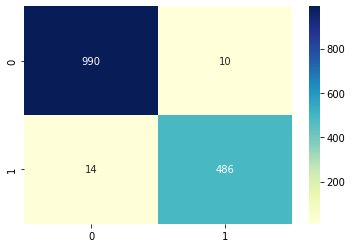

In [714]:
# Confusion matrix
class_names=[0,1] # name  of classes
fig, axes = plt.subplots(1, 1, figsize=(6,4))

tick_marks = np.arange(len(class_names))

ax.set_xticks(tick_marks, class_names)
ax.set_yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(arr_conf_KM, annot=True, cmap="YlGnBu" ,fmt='g', ax=axes)
ax.xaxis.set_label_position("top")

ax.set_title('Confusion matrix', y=1.1)
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label')
plt.show()

###### On a encore amélioré la prédiction des faux et vrais billets en utilisant cette fois ci 100% de l'information disponible.

### 7. Méthode de clustering hiérarchique<a id="C6."></a>

In [691]:
z = linkage(arr_bill_c_r, 'ward')
print(z)

[[3.61000000e+02 9.04000000e+02 1.69311896e-01 2.00000000e+00]
 [1.27000000e+02 7.35000000e+02 1.84330451e-01 2.00000000e+00]
 [3.08000000e+02 4.25000000e+02 1.97838166e-01 2.00000000e+00]
 ...
 [2.98700000e+03 2.99400000e+03 2.50253108e+01 6.31000000e+02]
 [2.99200000e+03 2.99600000e+03 3.29805968e+01 1.01200000e+03]
 [2.99500000e+03 2.99700000e+03 7.96383881e+01 1.50000000e+03]]


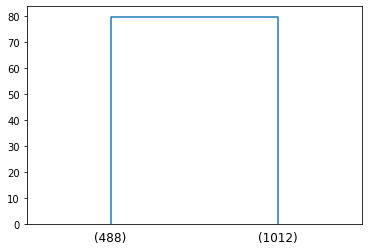

In [692]:
dendrogram(z, truncate_mode='lastp', color_threshold =0,p=2)
plt.show()

### 8. Méthode de regression logistique<a id="C7."></a>

##### 8.1. Préparation des données<a id="C8.1."></a>

In [693]:
print(df_billets_2['is_genuine'].head())
print(col_names)

0    True
1    True
2    True
3    True
4    True
Name: is_genuine, dtype: bool
['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length', 'status']


In [694]:
df_c_r = pd.DataFrame(data = arr_bill_c_r, columns=['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length'])
print(df_c_r.head())
print()
df_c_r['is_genuine'] = df_billets_2['is_genuine']
print(df_c_r.head())

   diagonal  height_left  height_right  margin_low  margin_up    length
0 -0.486540     2.774123      3.163240    0.055390  -1.128325  0.173651
1 -1.633729    -2.236535     -0.799668   -1.081987  -0.696799  0.471666
2  2.397823     1.504756     -1.291191   -0.126591  -0.912562  0.551901
3 -1.961498    -0.399294      0.060498   -1.309463  -0.610494  0.953075
4 -0.748754     0.836669     -1.414072   -0.672532   1.417677 -0.158750

   diagonal  height_left  height_right  margin_low  margin_up    length  \
0 -0.486540     2.774123      3.163240    0.055390  -1.128325  0.173651   
1 -1.633729    -2.236535     -0.799668   -1.081987  -0.696799  0.471666   
2  2.397823     1.504756     -1.291191   -0.126591  -0.912562  0.551901   
3 -1.961498    -0.399294      0.060498   -1.309463  -0.610494  0.953075   
4 -0.748754     0.836669     -1.414072   -0.672532   1.417677 -0.158750   

   is_genuine  
0        True  
1        True  
2        True  
3        True  
4        True  


In [695]:
df_c_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1500 non-null   float64
 1   height_left   1500 non-null   float64
 2   height_right  1500 non-null   float64
 3   margin_low    1500 non-null   float64
 4   margin_up     1500 non-null   float64
 5   length        1500 non-null   float64
 6   is_genuine    1500 non-null   bool   
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [696]:
# Remplacer les valeurs type string par des valeurs numériques ds 'is_genuine'

df_c_r['status'] = 1

cond = df_c_r['is_genuine'] == True

df_c_r.loc[cond, 'status'] = 0
# df_c_r = df_c_r.drop(['is_genuine'], axis=1)

print(df_c_r)

      diagonal  height_left  height_right  margin_low  margin_up    length  \
0    -0.486540     2.774123      3.163240    0.055390  -1.128325  0.173651   
1    -1.633729    -2.236535     -0.799668   -1.081987  -0.696799  0.471666   
2     2.397823     1.504756     -1.291191   -0.126591  -0.912562  0.551901   
3    -1.961498    -0.399294      0.060498   -1.309463  -0.610494  0.953075   
4    -0.748754     0.836669     -1.414072   -0.672532   1.417677 -0.158750   
...        ...          ...           ...         ...        ...       ...   
1495 -0.683201     1.170713      0.767063   -0.096260  -0.265273 -1.602978   
1496  0.758981     2.005822      1.596509    1.192767   0.942999 -1.958303   
1497 -0.519316    -0.065250      0.613462    1.556728   0.899846 -0.835016   
1498  0.332882     0.836669      0.429141    1.041117   1.331372 -0.491152   
1499 -1.600953     0.402412     -0.308144    0.222205   0.942999 -0.697470   

      is_genuine  status  
0           True       0  
1        

##### 8.2. Sélection des variables signifiantes, regression logistique<a id="C8.2."></a>

In [697]:
# Construction des données d'entrée selon la qualité de représentation des variables originelles
# sur les plans factoriels.
var_1 = ['height_right', 'height_left']
var_2 = ['margin_low', 'height_left', 'length']
var_3 = ['margin_low', 'height_right', 'length']
l_cols = [var_1, var_2, var_3]

##### 8.3. Regression logistique, matrices de confusion<a id="C8.3."></a>

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       209
           1       0.71      0.64      0.67        91

    accuracy                           0.81       300
   macro avg       0.78      0.76      0.77       300
weighted avg       0.81      0.81      0.81       300


Coefficients du modèle linéaire: [[1.21881723 0.91208126]]

Constante du modèle linéaire: [-1.01709123]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       209
           1       0.99      0.99      0.99        91

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300


Coefficients du modèle linéaire: [[ 2.83245543  0.6535214  -4.07399049]]

Constante du modèle linéaire: [-1.49873167]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       209
           1 

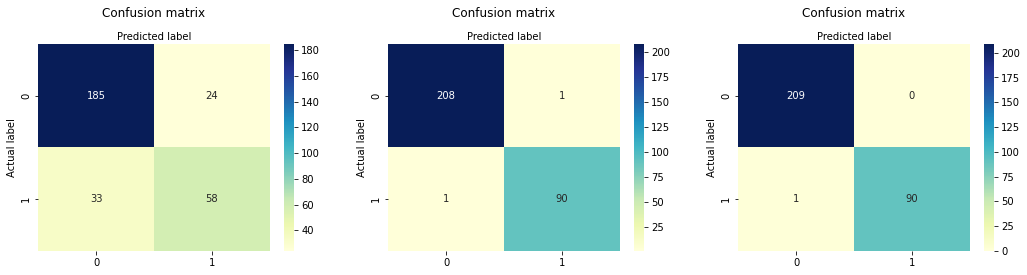

In [698]:
# Préparation affichhage confusion matrix
class_names=[0,1] # name  of classes
fig, axes = plt.subplots(1, 3, figsize=(15,4))
plt.tight_layout(pad=3.0)

tick_marks = np.arange(len(class_names))

l_arr = []


# Construction des données d'entrée: structure df.
for i in range(len(l_cols)):
    X = df_c_r.loc[:,l_cols[i]]
    y = df_c_r['status']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=20)
    
    logmodel = LogisticRegression()
    logmodel.fit(X_train, y_train)
    
    predictions = logmodel.predict(X_test)
    classification_report(y_test, predictions)
    
    print(classification_report(y_test, predictions))
    print()
    confusion_matrix(y_test, predictions)
    l_arr.append(confusion_matrix(y_test, predictions))
    
    print("Coefficients du modèle linéaire: {}".format(logmodel.coef_))
    print()
    print("Constante du modèle linéaire: {}".format(logmodel.intercept_))
    
    

for i, ax in enumerate(axes.flat):
    ax.set_xticks(tick_marks, class_names)
    ax.set_yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(l_arr[i], annot=True, cmap="YlGnBu" ,fmt='g', ax=ax)
    ax.xaxis.set_label_position("top")

    ax.set_title('Confusion matrix', y=1.1)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
plt.show()
    
    


In [699]:
# Synthèse: récapitulatif des données de sortie dans un df.
df_plan_1 = pd.DataFrame({'p_1_prédit_vrai': [185, 33], 'p_1_prédit_faux': [24, 58]}, index=['actuals_vrai', 'actuals_faux'])
print(df_plan_1)

df_plan_2 = pd.DataFrame({'p_2_prédit_vrai': [208, 1], 'p_2_prédit_faux': [1, 90]}, index=['actuals_vrai', 'actuals_faux'])
print(df_plan_2)

df_plan_3 = pd.DataFrame({'p_3_prédit_vrai': [209, 1], 'p_3_prédit_faux': [0, 90]}, index=['actuals_vrai', 'actuals_faux'])
print(df_plan_3)

tot = (df_plan_1.sum()).sum()


              p_1_prédit_vrai  p_1_prédit_faux
actuals_vrai              185               24
actuals_faux               33               58
              p_2_prédit_vrai  p_2_prédit_faux
actuals_vrai              208                1
actuals_faux                1               90
              p_3_prédit_vrai  p_3_prédit_faux
actuals_vrai              209                0
actuals_faux                1               90


In [700]:
# Synthèse: récapitulatif des données de sortie dans un df en %.

df_plan_1 = df_plan_1.loc[:,:].apply(lambda x: x/tot)
# print(df_plan_1)


df_plan_2 = df_plan_2.loc[:,:].apply(lambda x: x/tot)
# print(df_plan_2)

df_plan_3 = df_plan_3.loc[:,:].apply(lambda x: x/tot)
# print(df_plan_3)

df_plan_concat = pd.concat([df_plan_1, df_plan_2, df_plan_3], axis=1)
print(df_plan_concat)

              p_1_prédit_vrai  p_1_prédit_faux  p_2_prédit_vrai  \
actuals_vrai         0.616667         0.080000         0.693333   
actuals_faux         0.110000         0.193333         0.003333   

              p_2_prédit_faux  p_3_prédit_vrai  p_3_prédit_faux  
actuals_vrai         0.003333         0.696667              0.0  
actuals_faux         0.300000         0.003333              0.3  


In [701]:
df_plan_concat = pd.DataFrame({'plan_1':[round(df_plan_concat.iloc[0,0] + df_plan_concat.iloc[1,1], 3), 
                                        round(df_plan_concat.iloc[0,1] + df_plan_concat.iloc[1,0], 3)], 
                               'plan_2':[round(df_plan_concat.iloc[0,2] + df_plan_concat.iloc[1,3], 3),
                                        round(df_plan_concat.iloc[1,2] + df_plan_concat.iloc[0,3], 3)], 
                               'plan_3':[round(df_plan_concat.iloc[0,4] + df_plan_concat.iloc[1,5], 3),
                                        round(df_plan_concat.iloc[1,4] + df_plan_concat.iloc[0,5], 3)]}, 
                              index = ['bonne prédiction', 'mauvaise prédiction'])


In [702]:
df_plan_concat

,plan_1,plan_2,plan_3
bonne prédiction,0.81,0.993,0.997
mauvaise prédiction,0.19,0.007,0.003


###### Les résultats obtenus par regression logistique sont meilleurs que ceux obtenur par la méthodes des K-Means. Par ailleurs, ce sont les variables sélectionnées à partir de leur représentation dans le plan factoriel 3 qui sont le plus à même de caractériser les dimensions des individus et de les différencier.

##### 8.4. Regression logistique, matrices de confusion à partir des données originelles<a id="C8.4."></a>

In [703]:
X = df_c_r.iloc[:,0:6]
y = df_c_r['status']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=20)
    
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
# print(X_train)
    
predictions = logmodel.predict(X_test)
print(predictions)
classification_report(y_test, predictions)
    
print(classification_report(y_test, predictions))
print()
print("Coefficients du modèle linéaire: {}".format(logmodel.coef_))
print()
print("Constante du modèle linéaire: {}".format(logmodel.intercept_))
print()


arr_conf_RL = np.array([2,2])
arr_conf_RL = confusion_matrix(y_test, predictions)
print(arr_conf_RL)


[0 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0
 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0
 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0
 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1
 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0
 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 1 0]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       209
           1       1.00      0.99      0.99        91

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300


Coefficients du modèle linéaire: [[-0.19588424  0.50098615  0.

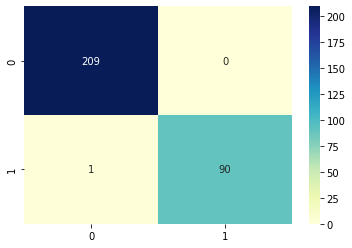

In [704]:
# Confusion matrix
class_names=[0,1] # name  of classes
fig, axes = plt.subplots(1, 1, figsize=(6,4))

tick_marks = np.arange(len(class_names))

ax.set_xticks(tick_marks, class_names)
ax.set_yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(arr_conf_RL, annot=True, cmap="YlGnBu" ,fmt='g', ax=axes)
ax.xaxis.set_label_position("top")

ax.set_title('Confusion matrix', y=1.1)
ax.set_ylabel('Actual label')
ax.set_xlabel('Predicted label')
plt.show()

In [705]:
print(arr_conf_RL)
tot_RL=np.sum(arr_conf_RL)
print(tot_RL)


good_pred = arr_conf_RL[0][0] + arr_conf_RL[1][1]
bad_pred = arr_conf_RL[1][0] + arr_conf_RL[0][1]

[[209   0]
 [  1  90]]
300


In [706]:
df_conf_RL = pd.DataFrame({'Valeur': [good_pred, bad_pred], '%_RL':[round((good_pred)/tot_RL, 3),round((bad_pred)/tot_RL, 3)]}, index=['good_pred', 'bad_pred'])

In [707]:
df_conf_RL

,Valeur,%_RL
good_pred,299,0.997
bad_pred,1,0.003


In [708]:
# Graphique de la courbe de confiance dans le modèle (ROC curve)

# 1. Calculer les valeurs de "true positive" et "false positive"
y_pred_proba = logmodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
print(y_pred_proba)
# print(y_pred_proba.shape)
print()
print(fpr, tpr, _)

[4.28237840e-03 8.99991923e-04 9.99955444e-01 9.99664738e-01
 2.08692966e-03 2.34642604e-05 9.92150151e-01 4.81348951e-05
 9.99952743e-01 9.98036251e-01 9.99801196e-01 1.57240025e-02
 9.99640723e-01 1.93634576e-02 3.72971140e-04 1.77288579e-03
 9.99988852e-01 9.84566268e-01 2.49021944e-02 9.99289049e-01
 2.50086508e-05 1.24059375e-04 1.41083614e-04 9.69624399e-04
 1.82966366e-03 5.99210133e-03 8.73013490e-05 8.86258084e-01
 5.21770931e-03 2.27540982e-05 4.90874112e-06 3.39692776e-03
 9.96289779e-01 5.03715929e-04 9.99993563e-01 7.87056577e-04
 5.36418417e-02 8.40694600e-01 4.37972884e-04 9.94766475e-01
 9.55893261e-01 9.89793849e-04 2.37473545e-03 3.61650235e-04
 8.26975911e-03 8.27843164e-05 5.59522782e-03 9.97497008e-03
 1.95543484e-03 1.72471112e-04 3.22927795e-05 9.97074664e-01
 4.98375432e-04 9.96723588e-01 1.06128212e-03 1.58446553e-03
 1.34354645e-02 9.01867144e-03 1.31188512e-02 9.75266542e-01
 6.00753713e-03 1.98373540e-03 1.12874424e-02 2.97946661e-02
 5.32380608e-04 9.976057

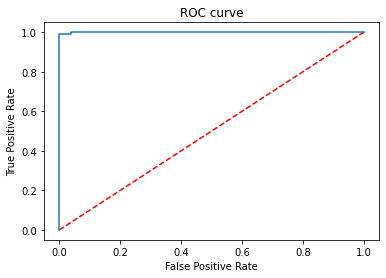

In [709]:
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 9. Synthèse.<a id="C9."></a>

###### Après avoir étudié plusieurs modéles et les avoir testés avec des données d'entrée plus ou moins riches, sur la base du test ci-dessous, on conclue que le modèle le plus performant est la regression logistique d'une part et d'autre part on peut aussi se rendre compte de l'importance de la qualité des données d'entrée puisque, en améliorant la qualité des données notamment pour la regression logistique, on obtient une détection complète des faux et vrais billets.
###### Cependant les deux méthodes donnent des résultats trés proches, ce que l'on peut vérifier par un test de Mann Whitney.

In [710]:
# Test de Mann Whitney.
# Echantillons à tester:

df_stats = pd.concat([df_conf_RL.iloc[:,1], df_conf_KM.iloc[:,1]], axis=1)


In [711]:
df_stats

,%_RL,%_KM
good_pred,0.997,0.984
bad_pred,0.003,0.016


In [712]:
stats.mannwhitneyu(df_stats.iloc[:,0], df_stats.iloc[:,1])

MannwhitneyuResult(statistic=2.0, pvalue=1.0)

###### La p-value est >0.05 on ne peut donc pas rejeter l'hypothèse nulle consistant à dire que les deux méthodes sont trés proches l'une de l'autre.

In [715]:
def verif(path_input_file, path_output_file):

    df_billets_verif = pd.read_csv(path_input_file, sep=';')
    
    
    # centrage - réduction des valeurs
    arr_billets_verif = df_billets_verif.values
    init = StandardScaler()
    arr_billets_verif_c_r = init.fit_transform(arr_billets_verif)
    
    
    # Mettre valeurs centyrées - réduites ds df
    df_billets_verif_c_r = pd.DataFrame(arr_billets_verif_c_r, 
                                        columns=['diagonal', 'height_left', 
                                                 'height_right', 'margin_low', 
                                                 'margin_up', 'length'])
    
    # Former l'échantillon de test avec les 6 variables
    X_test = df_billets_verif_c_r.iloc[:,0:6]
    
    # Utiliser "logmodel", modèle de classification, sur X_test
    new_pred = logmodel.predict(X_test)
    
    
    # Ajouter au df les colonnes intéressantes
    df_billets_verif_c_r['new_pred'] = new_pred
    df_billets_verif_c_r['proba_0'] = logmodel.predict_proba(X_test)[:,0]
    df_billets_verif_c_r['proba_1'] = logmodel.predict_proba(X_test)[:,1]
    
    
    # Convertir le résultat en format "csv" et le sauvegarder
    df_billets_verif_c_r.to_csv(path_output_file, index=False)
    return



In [716]:
path_input_file = '/Users/olivierdebeyssac/Open Classrooms/Projet_8/billets_test_verif.csv'
path_output_file = '/Users/olivierdebeyssac/Open Classrooms/Projet_8/billets_verif_output.csv'

verif(path_input_file, path_output_file)

In [730]:
# Matrice symétrique A
arr_ = np.array([[1, 2, 3], [2,1,3], [3,2,1]])
print(arr_)

[[1 2 3]
 [2 1 3]
 [3 2 1]]


In [731]:
# Calcul valeurs propres et vecteurs propres
eig_val, eig_vec = np.linalg.eig(arr_)
print(eig_val)
print()
print(eig_vec)

[ 6. -2. -1.]

[[-0.57735027 -0.45749571  0.34815531]
 [-0.57735027 -0.45749571 -0.87038828]
 [-0.57735027  0.76249285  0.34815531]]


In [733]:
# Inverse de la matrice des vecteurs propres, eig_vec
eig_vec_inv = np.linalg.inv(eig_vec)
print(eig_vec_inv)


[[-5.87660095e-01 -4.94871659e-01 -6.49519053e-01]
 [-8.19679816e-01 -7.46815633e-17  8.19679816e-01]
 [ 8.20651807e-01 -8.20651807e-01  4.48089380e-16]]


In [734]:
# Calcul matriciel de inverse de la matrice des vecteurs propres avec A

temp = np.dot(eig_vec_inv, arr_)
print(temp)

[[-3.52596057e+00 -2.96922996e+00 -3.89711432e+00]
 [ 1.63935963e+00  1.11022302e-15 -1.63935963e+00]
 [-8.20651807e-01  8.20651807e-01 -1.77235667e-15]]


In [736]:
# Calcul matriciel de temp avec matrice des vecteurs propres qui doit donner une matrice diagonalisée avec 
# sur la diagonale, les valeurs propres
diag = np.round(np.dot(temp, eig_vec), 2)
print(diag)


[[ 6.  0.  0.]
 [-0. -2. -0.]
 [ 0. -0. -1.]]
